In [1]:
import os
import sys
import time
import json
from datetime import datetime

import numpy as np
import pandas as pd

from models import models
from utils import read_df, read_numpy, write_df
import logging

from evaluate import rps

In [2]:
#Model imports
import numpy as np
import json
import os
import pandas as pd

from tqdm.auto import tqdm
from multiprocessing import Pool
from iteround import saferound
import scipy.stats as st
import tweedie
from category_encoders import OrdinalEncoder
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=50)

from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

from model import Model
from utils import read_df

INFO: Pandarallel will run on 50 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
DATASET_PATH = './dataset/processed/train_v1'
TEST_DATA_FILENAME = 'test_data.csv'
GROUND_TRUTH_FILENAME = 'test_ground_truth.npy'
TRAIN_DATA_FILENAME = 'train_data.parquet'
TRAIN_DATA_PROCESSED_FILENAME = 'train_data_features.parquet'
ITEM_DATA_FILEPATH = './dataset/items_static_metadata_full.jl'

TRAIN_DATA_X_FILENAME = 'train_data_x.parquet'
TRAIN_DATA_Y_FILENAME = 'train_data_y.parquet'
TRAIN_DATA_X_PROCESSED_FILENAME = 'train_data_x_features.parquet'
TRAIN_DATA_Y_PROCESSED_FILENAME = 'train_data_y_features.parquet'

TEST_FROMTRAIN_DATA_LAST29_FILENAME = 'test_fromtrain_data_last29.parquet'
TEST_FROMTRAIN_DATA_LAST29_PROCESSED_FILENAME = 'test_fromtrain_data_last29_features.parquet'

In [4]:
dateset_indexes = [0]
model_name = 'simple_first_30_days_fixed_spike'

In [5]:
dataset_index = dateset_indexes[0]
dataset_current_path = os.path.join(DATASET_PATH, str(dataset_index))

test_data_filepath = os.path.join(dataset_current_path, TEST_DATA_FILENAME)
ground_truth_filepath = os.path.join(dataset_current_path, GROUND_TRUTH_FILENAME)
train_data_filepath = os.path.join(dataset_current_path, TRAIN_DATA_FILENAME)
train_data_processed_filepath = os.path.join(dataset_current_path, TRAIN_DATA_PROCESSED_FILENAME)

train_data_x_filepath = os.path.join(dataset_current_path, TRAIN_DATA_X_FILENAME)
train_data_y_filepath = os.path.join(dataset_current_path, TRAIN_DATA_Y_FILENAME)
train_data_x_processed_filepath = os.path.join(dataset_current_path, TRAIN_DATA_X_PROCESSED_FILENAME)
train_data_y_processed_filepath = os.path.join(dataset_current_path, TRAIN_DATA_Y_PROCESSED_FILENAME)

test_fromtrain_data_last29_filepath = os.path.join(dataset_current_path, TEST_FROMTRAIN_DATA_LAST29_FILENAME)
test_fromtrain_data_last29_processed_filepath = os.path.join(dataset_current_path, TEST_FROMTRAIN_DATA_LAST29_PROCESSED_FILENAME)

In [6]:
#model = models['xgboost_v1']('./dataset')
#model.prepare_data()
#model.train()
#model.predict('./dataset/test_data.csv')

In [7]:
df_train = read_df(train_data_filepath)
df_item = read_df(ITEM_DATA_FILEPATH)

In [8]:
df_test = read_df(test_data_filepath)
ground_truth = read_numpy(ground_truth_filepath)

df_train_processed = read_df(train_data_processed_filepath)

In [9]:
#df_train_x = read_df(train_data_x_filepath)
#df_train_x = read_df(train_data_y_filepath)

df_test_fromtrain_x_features = read_df(test_fromtrain_data_last29_processed_filepath)
df_train_x_features = read_df(train_data_x_processed_filepath)
df_train_y_features = read_df(train_data_y_processed_filepath)

In [10]:
x_df = df_train_x_features.sample(frac=1, random_state=42).reset_index(drop=True).copy()

In [11]:
y_df = df_train_y_features.set_index('sku').loc[x_df['sku']].reset_index().copy()

In [12]:
all_columns = ['item_domain_id', 'item_id', 'item_title', 'site_id', 'sku',
       'product_id', 'product_family_id', 'count', 'date_first', 'date_last',
       'date_diff', 'date_first_day', 'date_first_month', 'date_last_day',
       'date_last_month', 'sold_quantity_first', 'sold_quantity_last',
       'sold_quantity_sum', 'sold_quantity_mean', 'sold_quantity_std',
       'sold_quantity_min', 'sold_quantity_max', 'sold_quantity_mode',
       'sold_quantity_mode_tx', 'current_price_first', 'current_price_last',
       'current_price_sum', 'current_price_mean', 'current_price_std',
       'current_price_min', 'current_price_max', 'current_price_mode',
       'current_price_mode_tx', 'minutes_active_first', 'minutes_active_last',
       'minutes_active_sum', 'minutes_active_mean', 'minutes_active_std',
       'minutes_active_min', 'minutes_active_max', 'minutes_active_mode',
       'minutes_active_mode_tx', 'currency_first', 'currency_last',
       'currency_mode', 'currency_mode_tx', 'listing_type_first',
       'listing_type_last', 'listing_type_mode', 'listing_type_mode_tx',
       'shipping_logistic_type_first', 'shipping_logistic_type_last',
       'shipping_logistic_type_mode', 'shipping_logistic_type_mode_tx',
       'shipping_payment_first', 'shipping_payment_last',
       'shipping_payment_mode', 'shipping_payment_mode_tx',
       'minutes_active_series', 'current_price_series',
       'sold_quantity_series']

In [13]:
categorical_columns = ['site_id', 'item_id']
categorical_columns_with_nan = ['item_domain_id', 'product_id', 'product_family_id']
categorical_columns_composed = ['currency', 'listing_type', 'shipping_logistic_type', 'shipping_payment']
categorical_composed_suffix = ['_first', '_last', '_mode']

categorical_columns = categorical_columns + categorical_columns_with_nan
for category_name in categorical_columns_composed:
    for suffix in categorical_composed_suffix:
        categorical_columns.append(category_name+suffix)

numeric_columns = ['count', 'date_first_day', 'date_first_month', 'date_last_day', 'date_last_month']  
numeric_columns_composed = ['sold_quantity', 'current_price', 'minutes_active']
numeric_composed_suffix = ['_first', '_last', '_mode', '_mode_tx', '_sum', '_mean', '_std', '_min', '_max']

for numeric_name in numeric_columns_composed:
    for suffix in numeric_composed_suffix:
        numeric_columns.append(numeric_name+suffix)

categorical_to_numeric_composed_suffix = ['_mode_tx']
        
for category_name in categorical_columns_composed:
    for suffix in categorical_to_numeric_composed_suffix:
        numeric_columns.append(category_name+suffix)
        
series_columns = ['sold_quantity_series', 'current_price_series', 'minutes_active_series']
series_columns_headers = {}

series_columns_max = x_df['count'].max()
for series_name in series_columns:
    series_columns_headers[series_name] = [series_name+'_'+str(i) for i in range(series_columns_max)]
    numeric_columns = numeric_columns + series_columns_headers[series_name]

features = numeric_columns + categorical_columns

print('Number of features:', len(features), 'Non-used features: ', set(all_columns) - set(features) - set(series_columns))

Number of features: 140 Non-used features:  {'item_title', 'date_last', 'date_diff', 'date_first', 'sku'}


In [14]:
for column in numeric_columns_composed:
    x_df[column+'_std'] = x_df[column+'_std'].fillna(0)
    y_df[column+'_std'] = y_df[column+'_std'].fillna(0)

In [15]:
for column in categorical_columns_with_nan:    
    x_df[column] = x_df[column].astype(str).astype("category")
    y_df[column] = y_df[column].astype(str).astype("category")

In [16]:
categorical_pandas_order = {}

for column in categorical_columns:    
    x_df[column] = x_df[column].astype("category")
    categorical_pandas_order[column] = x_df[column].cat.categories
    y_df[column] = y_df[column].astype("category")
    y_df[column] = y_df[column].cat.set_categories(categorical_pandas_order[column], ordered=True)

In [17]:
for column in categorical_columns:
    x_df[column] = x_df[column].cat.codes
    y_df[column] = y_df[column].cat.codes

In [18]:
for column in  series_columns:
    def series_to_df(data):
        result = np.ones(series_columns_max)*-1
        data = json.loads(data)
        index_limit = len(data) if len(data) <= series_columns_max else series_columns_max
        result[-index_limit:] = data[-index_limit:]
        #return result
        return pd.Series(result, index=series_columns_headers[column])

    series_x_df = x_df[column].parallel_apply(series_to_df)
    series_y_df = y_df[column].parallel_apply(series_to_df)

    x_df = x_df.join(series_x_df)
    y_df = y_df.join(series_y_df)

In [19]:
X = x_df[features].values

In [20]:
#y = y_df[['sold_quantity_mean', 'sold_quantity_std']].values

In [21]:
y = np.array(list(y_df['sold_quantity_series'].apply(json.loads).values))
y = y.cumsum(axis=1)

In [22]:
y_ts = np.zeros(len(y))
y_td = np.zeros(len(y))

for i, t in enumerate(y):
    where_non_zero = np.where(t > 0)[0]
    if len(where_non_zero) == 0:
        y_ts[i] = 0
        y_td[i] = 0
        continue
    j = np.random.choice(where_non_zero)
    y_ts[i] = t[j]
    y_td[i] = np.where(t == t[j])[0][0]

In [23]:
X = np.concatenate((X, np.reshape(y_ts, (-1, 1))), axis=1)
y = y_td

In [24]:
test_x_df = df_test_fromtrain_x_features.set_index('sku').loc[df_test['sku']].reset_index().copy()
for column in numeric_columns_composed:
    test_x_df[column+'_std'] = test_x_df[column+'_std'].fillna(0)
for column in categorical_columns_with_nan:    
    test_x_df[column] = test_x_df[column].astype(str).astype("category")
for column in categorical_columns:
    test_x_df[column] = test_x_df[column].astype("category")
    categorical_order = list(categorical_pandas_order[column])
    if len(test_x_df[column].cat.categories) != len(categorical_pandas_order[column]):
        for cat in set(test_x_df[column].cat.categories) - set(categorical_order):
                categorical_order.append(cat)
    test_x_df[column] = test_x_df[column].cat.set_categories(categorical_order, ordered=True)
    test_x_df[column] = test_x_df[column].cat.codes
for column in  series_columns:
    def series_to_df(data):
        result = np.ones(series_columns_max)*-1
        data = json.loads(data)
        index_limit = len(data) if len(data) <= series_columns_max else series_columns_max
        result[-index_limit:] = data[-index_limit:]
        #return result
        return pd.Series(result, index=series_columns_headers[column])

    series_x_test_df = test_x_df[column].parallel_apply(series_to_df)

    test_x_df = test_x_df.join(series_x_test_df)

X_test = test_x_df[features].values

In [25]:
X_test = np.concatenate((X_test, np.reshape(df_test['target_stock'].values, (-1, 1))), axis=1)

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [49]:
#model = MultiOutputRegressor(XGBRegressor(
#                         n_estimators=800, max_depth=2, learning_rate=0.01,
#                         random_state=0, tree_method='gpu_hist',
#                         gpu_id=3), n_jobs=14)
model = XGBRegressor(n_estimators=1000, max_depth=5, learning_rate=0.1,
                    random_state=0, tree_method='gpu_hist',
                    gpu_id=3)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
mean_squared_error(y_val, y_pred)

37.63803880629391

In [28]:
np.abs(y_val - y_pred).std()

3.956177469824876

n_estimators=1000, max_depth=2, learning_rate=0.08, 38.77598546656583
model = XGBRegressor(n_estimators=1000, max_depth=2, learning_rate=0.2, 38.27539167059256
n_estimators=1000, max_depth=4, learning_rate=0.1, 37.546678641103945
n_estimators=1000, max_depth=6, learning_rate=0.1, 37.40878445231095

In [29]:
from skopt import gp_minimize

def tune(params):
    print('params', params)
    model = XGBRegressor(n_estimators=params[0], learning_rate=params[1],
                       max_depth=params[2],
                       subsample=params[3],
                       colsample_bytree=params[4],
                       min_child_weight=params[5],
                       random_state=42,
                       tree_method='gpu_hist', gpu_id=3)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return mean_squared_error(y_val, y_pred)

space = [(50, 100),
         (1e-3, 5e-1, 'log-uniform'),
         (1, 10),
         (0.05, 0.95),
         (0.05, 0.95),
         (1,300)]
res = gp_minimize(tune, space, random_state=42, verbose=1, acq_optimizer="lbfgs", n_jobs=10)

Iteration No: 1 started. Evaluating function at random point.
params [90, 0.0031266912307463765, 8, 0.5871651421518383, 0.4512494775682321, 31]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 2.4427
Function value obtained: 152.4192
Current minimum: 152.4192
Iteration No: 2 started. Evaluating function at random point.
params [73, 0.007955537581329894, 2, 0.6357996256539676, 0.10077042112439025, 217]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.6437
Function value obtained: 123.0748
Current minimum: 123.0748
Iteration No: 3 started. Evaluating function at random point.
params [97, 0.0010048514548852772, 10, 0.6057333586649449, 0.6004878444394529, 3]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 6.2660
Function value obtained: 190.3944
Current minimum: 123.0748
Iteration No: 4 started. Evaluating function at random point.
params [51, 0.026082611167204887, 5, 0.09199909689225388, 0.9263799669573134, 71]
Iteration No: 4 en

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/conda/envs/torch/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-29-f379f5c12938>", line 22, in <module>
    res = gp_minimize(tune, space, random_state=42, verbose=1, acq_optimizer="lbfgs", n_jobs=10)
  File "/opt/conda/envs/torch/lib/python3.6/site-packages/skopt/optimizer/gp.py", line 268, in gp_minimize
    callback=callback, n_jobs=n_jobs, model_queue_size=model_queue_size)
  File "/opt/conda/envs/torch/lib/python3.6/site-packages/skopt/optimizer/base.py", line 301, in base_minimize
    next_y = func(next_x)
  File "<ipython-input-29-f379f5c12938>", line 12, in tune
    model.fit(X_train, y_train)
  File "/home/edugarcia/dependencies/xgboost/python-package/xgboost/core.py", line 498, in inner_f
    return f(**kwargs)
  File "/home/edugarcia/dependencies/xgboost/python-package/xgboost/sklearn.py", line 790, in fit
    cal

TypeError: object of type 'NoneType' has no len()

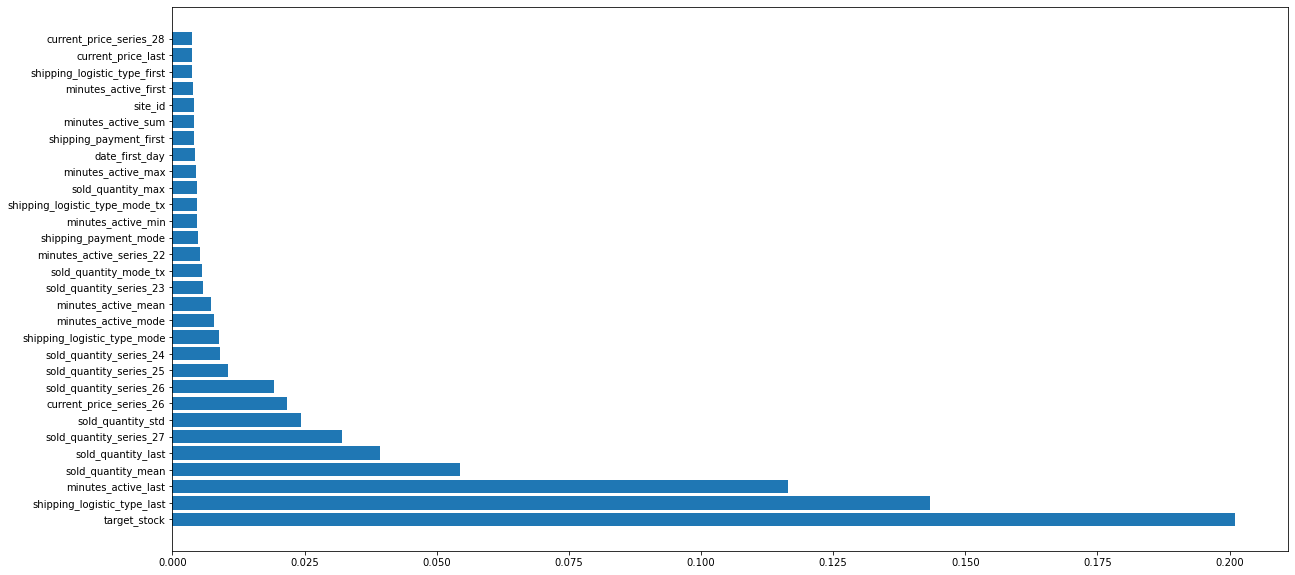

In [52]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(20, 10))
#features_importances = model.estimators_[-1].feature_importances_
features_importances = model.feature_importances_
sort = np.flip(np.argsort(features_importances))[0:30]
ax.barh(np.array(features + ['target_stock'])[sort], features_importances[sort])
plt.show()

In [47]:
variables_to_train = np.flip(np.argsort(features_importances))[0:30]
model = XGBRegressor(n_estimators=1000, max_depth=6, learning_rate=0.1,
                    random_state=0, tree_method='gpu_hist',
                    gpu_id=3)
model.fit(X_train[:, variables_to_train], y_train)
y_pred = model.predict(X_val[:, variables_to_train])
mean_squared_error(y_val, y_pred)

37.92603607312228

In [51]:
model = XGBRegressor(n_estimators=1000, max_depth=6, learning_rate=0.1,
                    random_state=0, tree_method='gpu_hist',
                    gpu_id=3)
model.fit(X, y)
preds = model.predict(X_test)

In [44]:
from scipy.stats import norm

def normal_probs(data):
    row, pred = data
    sku = row['sku']
    target_stock = row['target_stock']
    
    #sold_mean, sold_std = pred
    
    
    days_stockout = pred+1
    std_days = 7

    dist_model = norm(days_stockout,std_days)

    probalities = np.zeros(30)
    for i in range(1, 31):
        probalities[i-1] = (dist_model.cdf(i+1) - dist_model.cdf(i))

    if probalities.sum() == 0:
        probalities = np.ones(30) / 30

    probalities = (probalities/probalities.sum()).round(4)
    #probalities = saferound(probalities, places=4)
    return (sku, probalities)

predictions = np.zeros((len(df_test), 30))
i = 0
with Pool(100) as p:
    for data in tqdm(p.imap(normal_probs, zip(df_test.to_dict(orient='records'), preds)), total=len(df_test)):
        sku, probabilities = data
        predictions[i] = probabilities
        i += 1
        
from evaluate import rps
rps(predictions, ground_truth)

  0%|          | 0/143804 [00:00<?, ?it/s]

4.174173325008344

stds
5 - 4.262929225335388
7 - 4.198544959223248
10 - 4.3...
8 - 4.22
6 - 4.204762802167254

In [ ]:
from evaluate import rps
rps(predictions, ground_truth)

In [ ]:
from scipy.stats import norm

def normal_probs(data):
    row, preds = data
    sku = row['sku']
    target_stock = row['target_stock']
    
    sold_mean = preds.mean()
    sold_std = preds.std()
    
    c = preds.cumsum()  
    days_stockout = np.where(c>target_stock)[0]
    days_stockout = 30 if len(days_stockout) == 0 else days_stockout[0]+1
    
    std_days = (sold_std / sold_mean) * days_stockout

    dist_model = norm(days_stockout,std_days)

    probalities = np.zeros(30)
    for i in range(1, 31):
        probalities[i-1] = (dist_model.cdf(i+1) - dist_model.cdf(i))

    if probalities.sum() == 0:
        probalities = np.ones(30) / 30

    probalities = (probalities/probalities.sum()).round(4)
    #probalities = saferound(probalities, places=4)
    return (sku, probalities)

predictions = np.zeros((len(df_test), 30))
i = 0
with Pool(50) as p:
    for data in tqdm(p.imap(normal_probs, zip(df_test.to_dict(orient='records'), y_pred)), total=len(df_test)):
        sku, probabilities = data
        predictions[i] = probabilities
        i += 1